#Настройка классификатора


Импортируем необходимые бибилиотеки

In [36]:
import pandas as pd # Библиотека для работы с данными
import matplotlib.pyplot as plt # Библиотека для построения графиков
import seaborn as sns # Библиотека для построения графиков
import re # Библиотека для работы с регулярными выражениями
from wordcloud import WordCloud # Библиотека для построения облак слов
!pip install -U spacy
import spacy  # Библиотека для токенизации, удалени стоп-слов и лемматизации с целью анализа
!python -m spacy download ru_core_news_sm
import pickle # Библиотека для сохранения данных в процессе настройки классификатора
from sklearn.model_selection import train_test_split # Библиотека для разделения данных на выборки
from sklearn.pipeline import Pipeline # pipeline позволяет объединить в один блок трансформер и модель, что упрощает написание кода и улучшает его читаемость
from sklearn.feature_extraction.text import TfidfVectorizer # TfidfVectorizer преобразует тексты в числовые векторы, отражающие важность использования каждого слова из некоторого набора слов (количество слов набора определяет размерность вектора) в каждом тексте
from sklearn.ensemble import RandomForestClassifier # Классификатор случайного леса
from sklearn import metrics # набор метрик для оценки качества модели
from sklearn.model_selection import GridSearchCV # модуль поиска по сетке параметров
!pip install pymorphy2
import pymorphy2 # Установка библиотеки для предобработки текта (трансформер)
import numpy as np  # Библиотека для вычислений

     ---------------------------------------- 15.3/15.3 MB 7.6 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')


Загрузим предварительно скачанный датасет

In [27]:
df = pd.read_csv('C:/Users/User/Desktop/Диплом/dataset.csv')

In [28]:
df.head()

,title,content,url,class,source
0,Полет нормальный,Итоги прошедших выборов в Европейский парламен...,https://iz.ru/882384/nikolai-kaveshnikov/polet...,commentary,iz.ru
1,Приоритет министров,Отставка правительства и заявленные изменения ...,https://iz.ru/964707/anton-tabakh/prioritet-mi...,commentary,iz.ru
2,Платежные каникулы,"Прошлый , <NUM> год был примечателен тем , что...",https://iz.ru/1033704/valerii-dziubenko/platez...,commentary,iz.ru
3,Подсели на кредиты,В уходящем году закредитованность россиян дост...,https://iz.ru/958411/evgenii-mironiuk/podseli-...,commentary,iz.ru
4,Преодолеть ненависть,Едва ли не ежедневно средства массовой информа...,https://iz.ru/908454/berl-lazar/preodolet-nena...,commentary,iz.ru


Определим классы новостей, которые содержатся в наборе данных

In [29]:
df['class'].unique()

array(['commentary', 'persuasive_information', 'citizen_journalism',
       'real_news', 'satire'], dtype=object)

Изменим названия классов в наборе данных на 0 (фейк) и 1 (реальная новость)

In [30]:
df.loc[df['class'] == "commentary", 'class'] = '0'
df.loc[df['class'] == "persuasive_information", 'class'] = '0'
df.loc[df['class'] == "citizen_journalism", 'class'] = '0'
df.loc[df['class'] == "satire", 'class'] = '0'
df.loc[df['class'] == "real_news", 'class'] = '1'

Оценим распределение классов

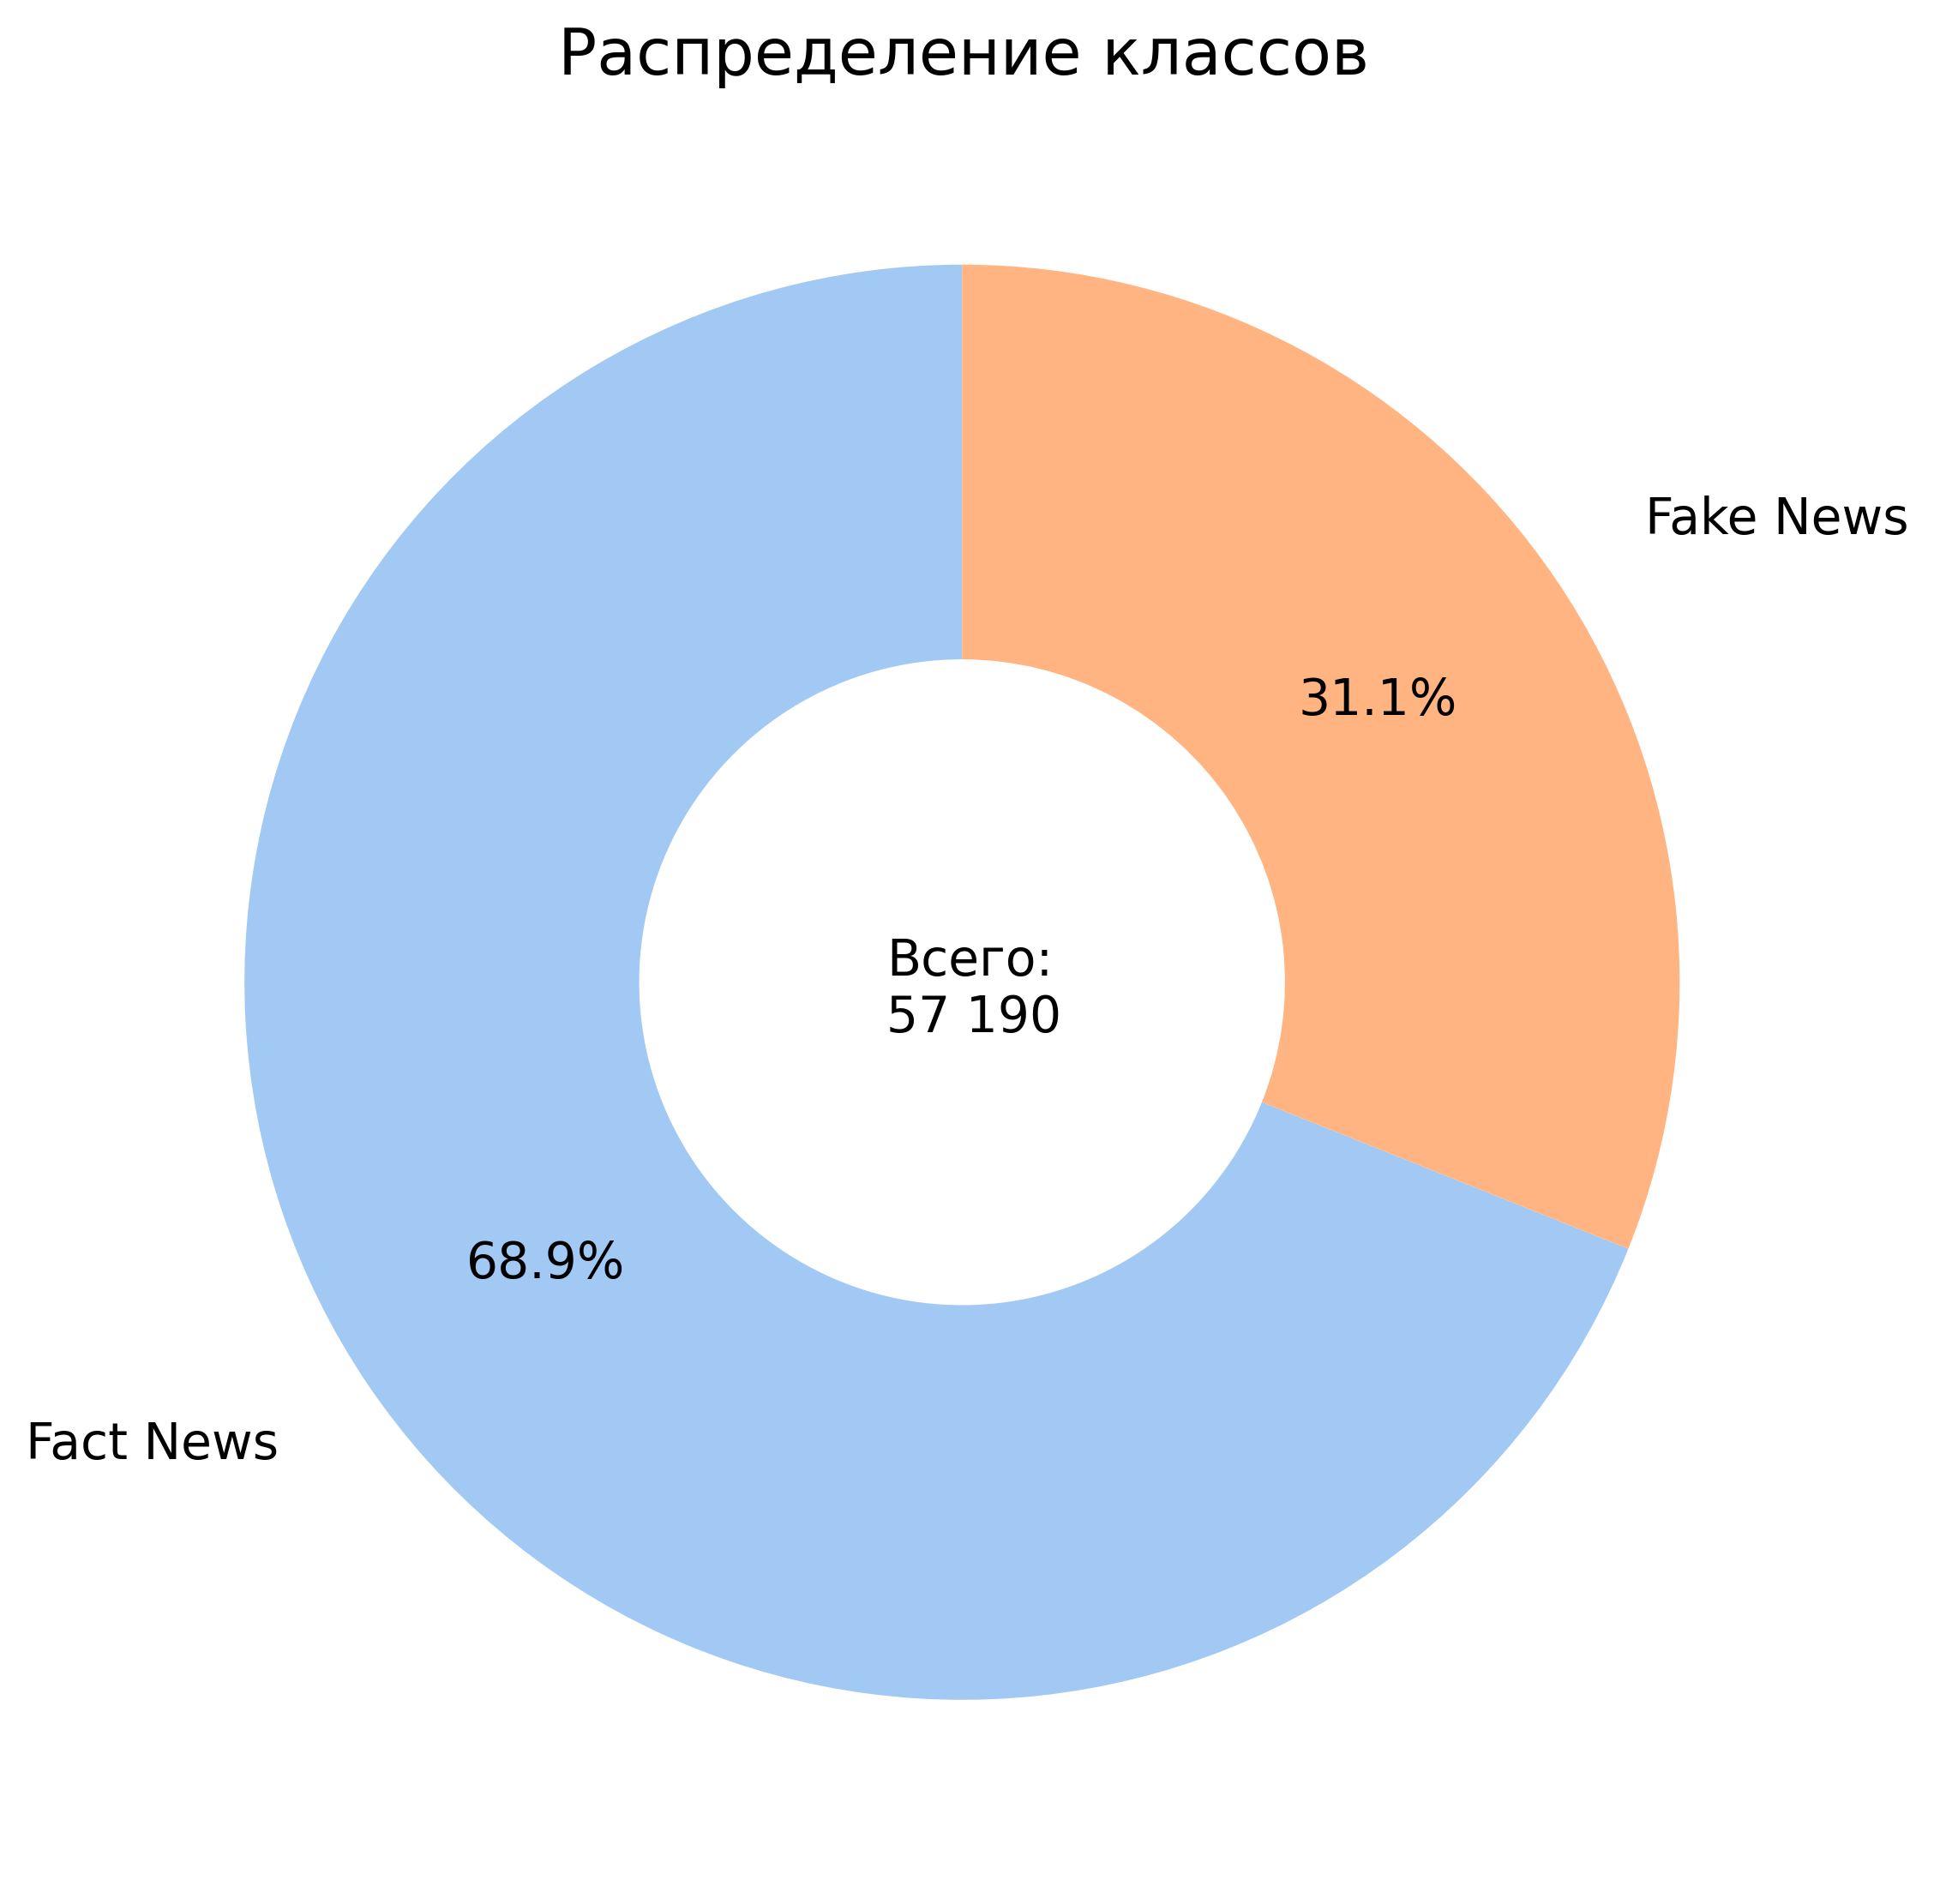

In [31]:
labels = list(['Fact News', 'Fake News'])
sizes = list(df['class'].value_counts())
explode = [0.1, 0]
colors = sns.color_palette('pastel')
fig, ax = plt.subplots(figsize=(8, 9), dpi=300)
ax.set_title('Распределение классов', fontdict={'fontsize': 18})
ax.pie(sizes, labels=labels, colors = colors, autopct='%1.1f%%', pctdistance = 0.7, labeldistance = 1.15, startangle=90, wedgeprops=dict(width=0.55), textprops={'fontsize': 14})
ax.axis('equal')
str = f'Всего:\n{df.shape[0]:,}'
plt.text (-0.105, -0.07, str.replace(','," "), fontdict={'fontsize': 14})
plt.show()

Очистим тексты новостей

(Перед предобработкой данных необходимо убрать пунктуацию, заменить несколько пробелы между терминами одним и удалить начальные и конечные пробелы)

In [32]:
def clean_text(text):
  text = re.sub(r'[^\w\s\d]', '',text)  # Удаление пунктуации
  text = re.sub(r'\s+', ' ',text)        # Замена нескольких пробелов на один
  text = re.sub(r'^\s+|\s+?$', '',text)  # Удаление начальных и конечных пробелов
  text = text.replace('\n', '')           # Удаление '\n'
  return text
for Class in ['1','0']:
  data = df[df['class'] == Class]['content']
  df.loc[df['class'] == Class,'content'] = data.map(clean_text)

In [33]:
df.head()

,title,content,url,class,source
0,Полет нормальный,Итоги прошедших выборов в Европейский парламен...,https://iz.ru/882384/nikolai-kaveshnikov/polet...,0,iz.ru
1,Приоритет министров,Отставка правительства и заявленные изменения ...,https://iz.ru/964707/anton-tabakh/prioritet-mi...,0,iz.ru
2,Платежные каникулы,Прошлый NUM год был примечателен тем что в пер...,https://iz.ru/1033704/valerii-dziubenko/platez...,0,iz.ru
3,Подсели на кредиты,В уходящем году закредитованность россиян дост...,https://iz.ru/958411/evgenii-mironiuk/podseli-...,0,iz.ru
4,Преодолеть ненависть,Едва ли не ежедневно средства массовой информа...,https://iz.ru/908454/berl-lazar/preodolet-nena...,0,iz.ru


Визуализируем частоту встречаемости различныз слов в текстах набора данных с помощью "Облака слов"

In [34]:
df_analysis = df.copy()
df_analysis['content'] = df_analysis.content.str.lower()

(-0.5, 799.5, 399.5, -0.5)

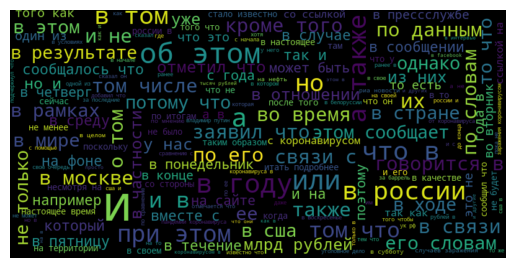

<Figure size 640x480 with 0 Axes>

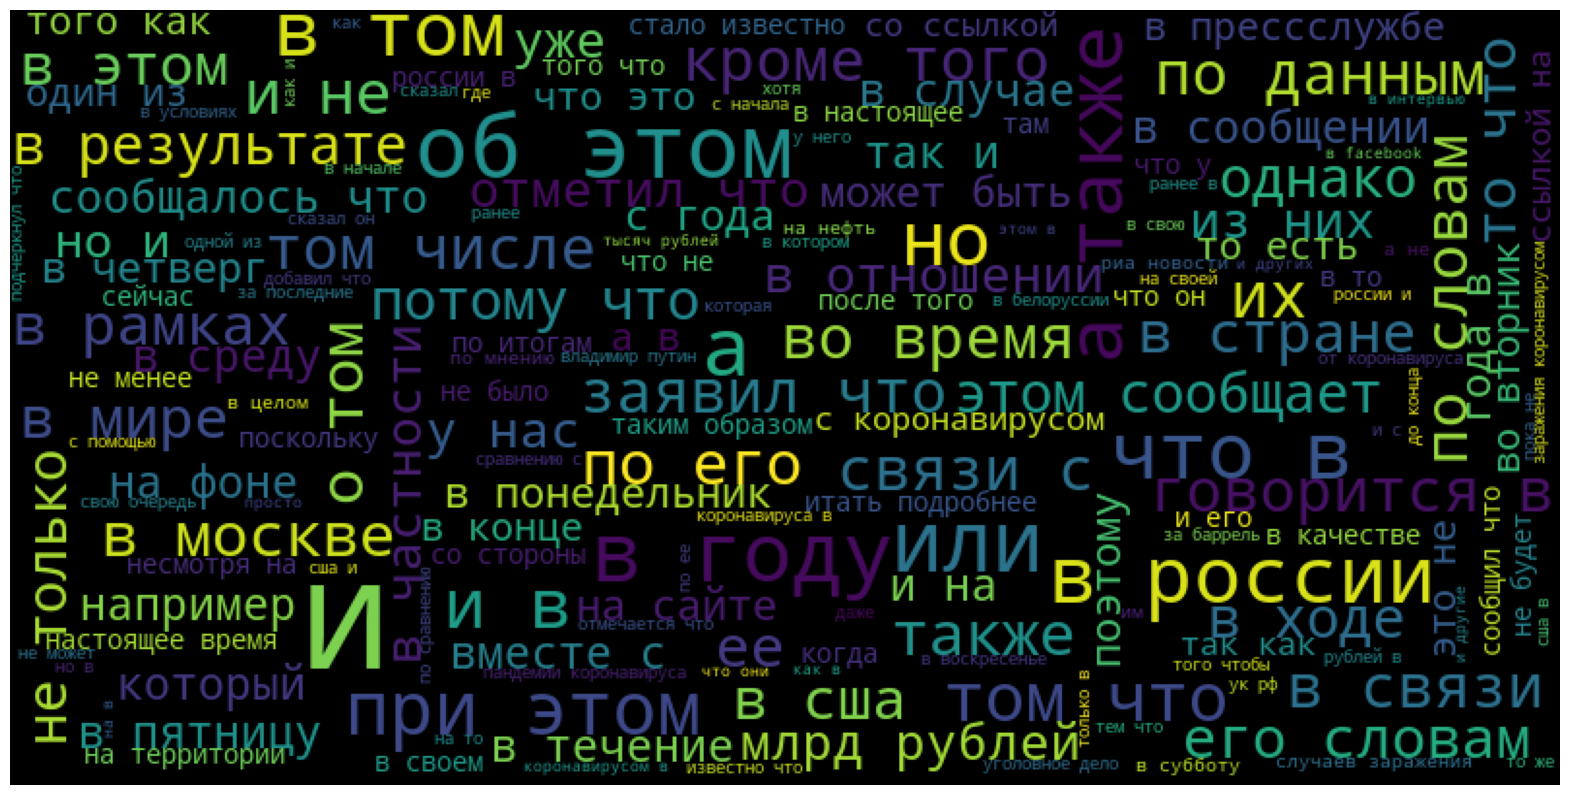

In [35]:
corpus = " ".join(content.replace('num', "").replace('datetime', "").replace('utf', "") for content in df_analysis.content)
def generateWordCloud(corpus: str, cmap: str):
    """
    Return a Word Cloud object generated from the corpus and color map parameter.
    """
    wordcloud = WordCloud(background_color = 'black', width = 800, height = 400,
                      colormap = cmap, max_words = 180, contour_width = 3,
                      max_font_size = 80, contour_color = 'steelblue',
                      random_state = 1, repeat = False)

    wordcloud.generate(corpus)

    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.figure()

    return wordcloud
 
# Generate the Word Clouds for each of the Corpuses and save them as a PNG file
generateWordCloud(corpus = corpus, cmap = 'viridis').to_file('dataset_wc.png')
image=plt.imread('dataset_wc.png')
fig=plt.figure(figsize=(20,30))
plt.imshow(image)
plt.axis('off')

Можно заметить, что в данный момент высокие частоты имеют союзы, предлоги и другие служебные части речи, не несущие смысловой нагрузки, а только выражающие семантико-синтаксические отношения между словами. Для того, чтобы результаты частотного анализа лучше отражали тематику текста, необходимо удалить типовые стоп-слова из текста.

Теперь токенизируем, удалим стоп-слова и лемматизируем тексты

In [ ]:
nlp = spacy.load('ru_core_news_sm')
df_analysis['content'] = df_analysis.apply(lambda row: " ".join(token.lemma_ for token in nlp(row['content']) if not token.is_stop), axis= 1 )
df_analysis.drop([3547,4655], inplace=True)
df_analysis.reset_index(drop=True , inplace=True )

(-0.5, 799.5, 399.5, -0.5)

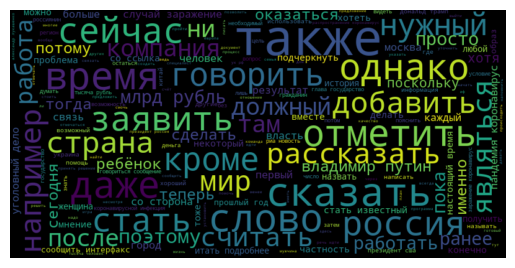

<Figure size 640x480 with 0 Axes>

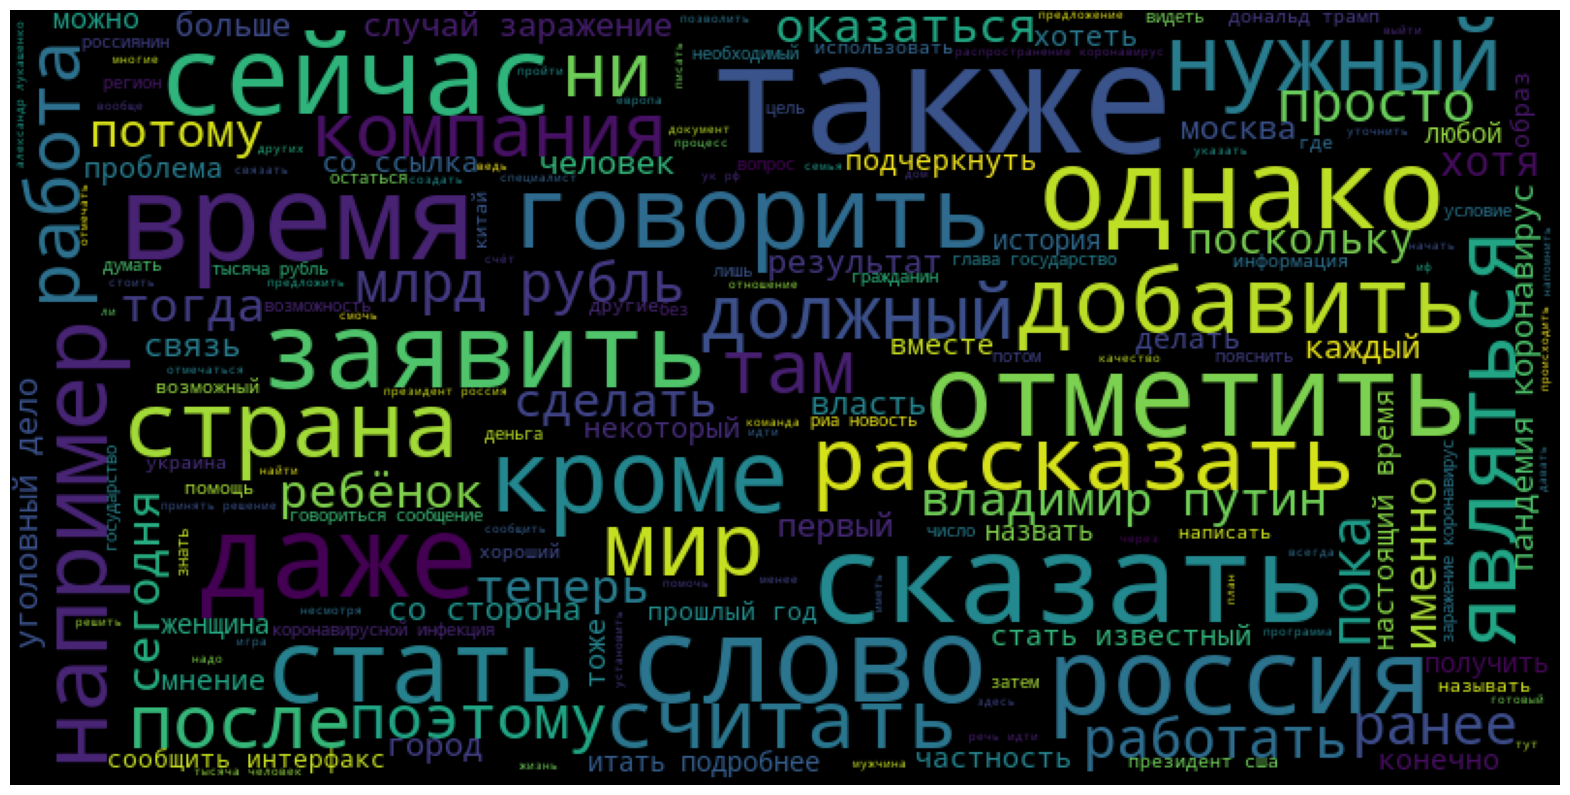

In [45]:
corpus = " ".join(content.replace('num', "").replace('datetime', "").replace('utf', "") for content in df_analysis.content)
def generateWordCloud(corpus: str, cmap: str):
    """
    Return a Word Cloud object generated from the corpus and color map parameter.
    """
    wordcloud = WordCloud(background_color = 'black', width = 800, height = 400,
                      colormap = cmap, max_words = 180, contour_width = 3,
                      max_font_size = 80, contour_color = 'steelblue',
                      random_state = 1, repeat = False)

    wordcloud.generate(corpus)

    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.figure()

    return wordcloud
 
# Generate the Word Clouds for each of the Corpuses and save them as a PNG file
generateWordCloud(corpus = corpus, cmap = 'viridis').to_file('dataset_wc.png')
image=plt.imread('dataset_wc.png')
fig=plt.figure(figsize=(20,30))
plt.imshow(image)
plt.axis('off')

Можно заметить, что исчезли местоимения и служебные слова: артикли, союзы, предлоги и т.д.

Разобьём данные на выборки

In [46]:
from sklearn.model_selection import train_test_split

In [47]:
X_train, X_test, y_train, y_test = train_test_split(df['content'], df['class'], test_size=0.1, random_state=42, stratify=df['source'])

In [48]:
X_train, X_test, y_train, y_test

(51435    Ограничения по провозу ручной клади на рейсах ...
 26210    Популярная британская поппевица Рита Ора подел...
 27569    На крупных заводах Белоруссии с утра DATETIME ...
 28896    Заслуженная артистка России Галина Киндинова п...
 11316    Бывший технический директор Локомотива Хасан Б...
                                ...                        
 47760    В приграничной с сирийским Идлибом турецкой пр...
 37595    Бизнесмен Александр Удодов муж сестры премьерм...
 24832    В NUM году Apple выпустит новый доступный смар...
 15222    Ученые СанктПетербургского политехнического ун...
 12412    Решение ряда мировых проблем в частности военн...
 Name: content, Length: 51471, dtype: object,
 46298    Калининградский областной суд передал присяжны...
 42970    Человеческий фактор рассматривается в качестве...
 5989     Среди юбилеев прошлого года есть место и тому ...
 8344     Как стало известно URL главный тренер Ак Барса...
 15790    Некоторые пожилые сотрудники центра имени Га

Сохраним полученные выборки

In [ ]:
pickle.dump(X_train, open('C:/Users/User/Desktop/Диплом/Другое/train_test_split/X_train.sav', 'wb'))
pickle.dump(X_test, open('C:/Users/User/Desktop/Диплом/Другое/train_test_split/X_test.sav', 'wb'))
pickle.dump(y_train, open('C:/Users/User/Desktop/Диплом/Другое/train_test_split/y_train.sav', 'wb'))
pickle.dump(y_test, open('C:/Users/User/Desktop/Диплом/Другое/train_test_split/y_test.sav', 'wb'))

In [ ]:
X_train = pickle.load(open('C:/Users/User/Desktop/Диплом/Другое/train_test_split/X_train.sav', 'rb'))
X_test = pickle.load(open('C:/Users/User/Desktop/Диплом/Другое/train_test_split/X_test.sav', 'rb'))
y_train = pickle.load(open('C:/Users/User/Desktop/Диплом/Другое/train_test_split/y_train.sav', 'rb'))
y_test = pickle.load(open('C:/Users/User/Desktop/Диплом/Другое/train_test_split/y_test.sav', 'rb'))

Создадим функцию векторизации

In [49]:
 def tfidf_tokenize(text):
    return list(map(lambda word: morph.parse(word)[0].normal_form, text.split()))

Создадим пайплай для векторизации текстов и настройки классификатора случайного леса

In [ ]:
rf_ppl_clf = Pipeline([('tfidf', TfidfVectorizer(tokenizer=tfidf_tokenize)),('sgd_clf', RandomForestClassifier(random_state=42))])

С помощью GridSearch попытаемся подобрать параметры настройки классификатора

In [ ]:
rf_ppl_clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function tfidf_tokenize at 0x0000011693C0A4C0>)),
                ('sgd_clf', RandomForestClassifier(random_state=42))])

In [ ]:
predicted_rf = rf_ppl_clf.predict(X_test)
print(metrics.classification_report(predicted_rf, y_test))

              precision    recall  f1-score   support

           0       0.69      0.96      0.80      1272
           1       0.99      0.87      0.93      4447

    accuracy                           0.89      5719
   macro avg       0.84      0.92      0.86      5719
weighted avg       0.92      0.89      0.90      5719



In [ ]:
pickle.dump(rf_ppl_clf, open('C:/Users/User/Desktop/Диплом/Другое/rf_ppl_clf.sav', 'wb'))

In [ ]:
rf_ppl_clf = pickle.load(open('C:/Users/User/Desktop/Диплом/Другое/rf_ppl_clf.sav', 'rb'))

In [ ]:
parameters = { 
              'sgd_clf__n_estimators':np.arange(80, 141, 20),
              'sgd_clf__max_depth':np.arange(220, 341, 40),
              }
best_forest_model = GridSearchCV(rf_ppl_clf,parameters,n_jobs=-1,cv=5)

In [ ]:
best_forest_model.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(tokenizer=<function tfidf_tokenize at 0x0000022095CBAEE0>)),
                                       ('sgd_clf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'sgd_clf__max_depth': array([220, 260, 300, 340]),
                         'sgd_clf__n_estimators': array([ 80, 100, 120, 140])})

In [ ]:
pickle.dump(best_forest_model, open('C:/Users/User/Desktop/Диплом/Другое/best_forest_model_new.sav', 'wb'))

In [ ]:
best_forest_model = pickle.load(open('C:/Users/User/Desktop/Диплом/Другое/best_forest_model_new.sav', 'rb'))

In [ ]:
print(best_forest_model.best_estimator_)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function tfidf_tokenize at 0x0000022095CBAEE0>)),
                ('sgd_clf',
                 RandomForestClassifier(max_depth=340, random_state=42))])


In [ ]:
print('Best score and parameter combination:')
print(best_forest_model.best_score_, best_forest_model.best_params_)

Best score and parameter combination:
0.889102603939563 {'sgd_clf__max_depth': 340, 'sgd_clf__n_estimators': 100}


In [ ]:
print(tfidf_X.best_estimator_)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(ngram_range=(1, 2),
                                 tokenizer=<function tfidf_tokenize at 0x0000011693C0A4C0>)),
                ('sgd_clf',
                 RandomForestClassifier(max_depth=40, n_estimators=15,
                                        random_state=42))])


In [ ]:
final_rf_ppl_clf = Pipeline([('tfidf', TfidfVectorizer(tokenizer=tfidf_tokenize)),('sgd_clf', RandomForestClassifier(random_state=42, n_estimators = 100, max_depth = 340))])

In [ ]:
final_rf_ppl_clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function tfidf_tokenize at 0x0000022095CBAEE0>)),
                ('sgd_clf',
                 RandomForestClassifier(max_depth=340, random_state=42))])

In [ ]:
predicted_final_rf = final_rf_ppl_clf.predict(X_test)
print(metrics.classification_report(predicted_final_rf, y_test))

              precision    recall  f1-score   support

           0       0.69      0.96      0.80      1273
           1       0.99      0.87      0.93      4446

    accuracy                           0.89      5719
   macro avg       0.84      0.92      0.86      5719
weighted avg       0.92      0.89      0.90      5719



In [ ]:
pickle.dump(final_rf_ppl_clf, open('C:/Users/User/Desktop/Диплом/Другое/final_rf_ppl_clf.sav', 'wb'))

In [ ]:
final_rf_ppl_clf = pickle.load(open('C:/Users/User/Desktop/Диплом/Другое/final_rf_ppl_clf.sav', 'rb'))